*best viewed in [nbviewer](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/results/notebooks/times_and_heads.ipynb)*

<center><h1>Biblical Hebrew Time Adverbials and their Semantic Heads</h1></center>
<center><h2 style="font-weight:normal">Cody Kingham</h2></center>
<center><h2><a href="../../docs/sponsors.md"><img height=15% width=15% src="../../docs/images/CambridgeU_BW.png"></a></h2></center>

In [1]:
! echo "last updated:"; date

last updated:
Tue  7 Jan 2020 17:03:00 GMT


## Introduction

Time adverbials are phrases which modify event time in a clause. These phrases typically contain a word that lexicalizes a time referent or quality. In traditional syntactic analysis, phrases are built up from their heads. Newer approaches like Construction Grammar (adopted herein) likewise use the notion of a "central idea" or "primary information bearing unit" (Croft 2001, 258–9). For the purpose of this study, we will refer to these units as "semantic heads." My [earlier analyses](../../archive/2019-10-31/analysis/exploratory/construction_distribution.ipynb) demonstrated that time adverbials contain heads that are statistically associated with the time function. Or, in other words, time adverbial head words are often specialized for the task of conveying time. This observation suggests that time adverbial heads are a good starting point for analyzing their semantics. They are the most specialized and specific semantic unit in the time adverbial.

The goals of this notebook is to:
* examine the distribution of time adverbials throughout the corpus
* identify and quantify the primary surface forms found amongst time adverbials as tagged in the project dataset (BHSA + modifications)
* identify and quantify the semantic head lexemes found on time adverbials in the dataset
* identify collocational tendencies of semantic head lexemes with other constructions

<hr>

<center><h2>Python</h2></center>

## Import Modules and Data

In [2]:
# standard packages
from pathlib import Path
import collections
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from adjustText import adjust_text

# custom package in /tools
from paths import figs
from helpers import Figures, convert2pandas, reverse_hb
from tf_tools.load import load_tf
from tf_tools.tokenizers import tokenize_surface
from cx_analysis.load import cxs
from cx_analysis.search import SearchCX
from stats.significance import contingency_table, apply_fishers
from stats.pca import plot_PCA

TF, API, A = load_tf(silent='deep')
A.displaySetup(condenseType='phrase')
F, E, T, L = A.api.F, A.api.E, A.api.T, A.api.L
se = SearchCX(A)
phrase2cxs = cxs['phrase2cxs']
class2cx = cxs['class2cx']
time_cxs = list(phrase2cxs.values())
sns.set(font_scale=1.5, style='whitegrid')

## Data Output

In [3]:
fg = Figures()

In [4]:
chapter = 'times_and_heads'
figures = figs.joinpath(chapter)
if not figures.exists():
    figures.mkdir(parents=True)
    
def fg_path(fg_name):
    return figures.joinpath(fg.title(fg_name, sep='.'))

## Dataset

The core data is from the ETCBC's BHSA syntactic corpus. This data has been further corrected and refined in the [bhsa](../../data/bhsa) and [cxs](../../data/cxs) directories of this project. BHSA provides the phrases themselves, which are in some cases corrected or modified. The syntactic structure of a phrase is subsequently analyzed using a series of constructional patterns (also in [cxs](../../data/cxs)). The structure is stored as a directed graph, and can be accessed using NetworkX methods. The data in the `cxs` import above is a Python dictionary which contains custom classes built for this project, the `Construction` object. Each object represents a phrase in the corpus, and contains the syntactic graphs. 

In [5]:
cxs.keys()

dict_keys(['wordcxs', 'phrase2cxs', 'class2cx'])

NB: Some Python-ese follows. `wordcxs` is a set of `Construction` objects that describe certain word instances in the Hebrew Bible. `phrase2cxs` is a dictionary containing mappings from a custom BHSA node number (integer), the `timephrase`, to its `Construction` object. `class2cx` is also a dictionary that maps certain pre-processed class tags to their respective constructions. For example, a tag "prep" contains all time phrases that begin with a preposition.

To illustrate, let's start with the custom BHSA node-type, the `timephrase`. This node is built from BHSA `phrase` nodes with a `function` value of `Time`. In some cases, BHSA separates these time phrases into seperate units. This separation is undesirable for the purposes of our analysis. The `timephrase` solves this problem by merging all adjacent phrases with a function of `Time`.

The numerical difference between `phrase` and `timephrase` is show below.

In [6]:
phrases = A.search('phrase function=Time')

  0.27s 4677 results


In [7]:
timephrases = A.search('timephrase')

  0.01s 4455 results


In [8]:
print(f'difference of {len(phrases) - len(timephrases)}')

difference of 222


The `timephrase` nodes have been wrapped into `Construction` objects and are stored under `time_cxs`. Let's have a look.

In [9]:
time_cxs[:5]

[[CX prep_ph (1, 2)],
 [CX prep_ph (687, 688, 689, 690, 691)],
 [CX prep_ph (697, 698, 699, 700, 701)],
 [CX prep (750,)],
 [CX prep (760,)]]

Each time construction contains a list of subphrases, which together function as a single time adverbial. Let's visualize the first one.

In [10]:
se.showcx(time_cxs[0][0])

{   '__cx__': 'prep_ph',
    'head': {'__cx__': 'cont', 'head': 2},
    'prep': {'__cx__': 'prep', 'head': 1}}



## Distribution

Before describing the time adverbials in depth, let's look at their distribution throughout the Hebrew Bible. We can visualize distribution as across a single dimension, a sequence of clauses.

For a set of clauses within a single book, `1–N`, create clusters of clauses, where `cluster = a 50 clause stretch`. If a book ends without an even 50 clauses, keep the uneven cluster as either its own cluster (if `N-clauses > 30`) or add it to last cluster in the book. 

In [11]:
# divide texts evenly into slices of 50 clauses

clause_segments = []

for book in F.otype.s('book'):
    
    clauses = list(L.d(book,'clause'))
    cluster = []
    
    for i, clause in enumerate(clauses):

        i += 1
        
        # skip non-Hebrew clauses
        lang = F.language.v(L.d(clause,'word')[0])
        if lang != 'Hebrew':
            continue

        cluster.append(clause)

        # create cluster of 50
        if (i and i % 50 == 0):
            clause_segments.append(cluster)
            cluster = []

        # deal with final uneven clusters
        elif i == len(clauses):
            if len(cluster) < 30:
                clause_segments[-1].extend(cluster) # add to last cluster
            else:
                clause_segments.append(cluster) # keep as cluster

Let's see how many segments have been made.

In [12]:
len(clause_segments)

1735

NB that several segments are slightly larger or smaller than 50. Here are the sizes of the under/over-sized clusters.

In [13]:
unevens = [cl for cl in clause_segments if len(cl) != 50]
print('lengths of uneven-sized clusters:')
for cl in unevens:
    print(len(cl), end='; ')

lengths of uneven-sized clusters:
37; 76; 77; 75; 59; 69; 46; 62; 35; 46; 44; 47; 74; 34; 78; 55; 39; 35; 35; 59; 54; 55; 36; 61; 41; 77; 34; 40; 36; 63; 56; 48; 73; 33; 38; 32; 27; 45; 74; 42; 64; 67; 

We will now iterate through the clusters and tally the number of time adverbials contained within each one. We track along the way the starting points for each new book in the corpus. Those are recorded so they can be plotted. The plot is presented further below as a strip-plot. 

In [14]:
# map book names for visualizing

# map grouped book names
book_map = {'1_Kings': 'Kings', '2_Kings':'Kings', '1_Samuel':'Samuel',
            '2_Samuel':'Samuel', '1_Chronicles':'Chronicles', '2_Chronicles':'Chronicles',}
# book of 12
for book in ('Hosea', 'Joel', 'Amos', 'Obadiah',
             'Jonah', 'Micah', 'Nahum', 'Habakkuk',
             'Zephaniah', 'Haggai', 'Zechariah',
             'Malachi'): 
    book_map[book] = 'Twelve'

# Megilloth
for book in ('Ruth', 'Lamentations', 'Ecclesiastes', 
             'Esther', 'Song_of_songs'): 
    book_map[book] = 'Megilloth'

# Dan-Neh
for book in ('Ezra', 'Nehemiah', 'Daniel'): 
    book_map[book] = 'Daniel-Neh'

In [15]:
# build strip plot data

strip_data = []
covered_nodes = set()
bookboundaries = {}

# time adverbial slots for testing whether
# a clause contains a TA or not
ta_slots = set(
    s for cx in time_cxs
        for sp in cx
            for s in sp.slots
)

# iterate through constructions and gather book data
this_book = None

for i, seg in enumerate(clause_segments):
    
    for cl in seg:
        book, chapter, verse = T.sectionFromNode(cl)
        this_book = book_map.get(book, book)
        
        if set(L.d(cl,'word')) & ta_slots:
            strip_data.append(i+1)
            
        # add book boundaries for plotting
        if this_book not in bookboundaries: 
            bookboundaries[this_book] = i+1

Distribution of Time Function Constructions by segments of ~50 clauses (smaller books are grouped together)
x-axis: Nth clause cluster
y-axis: random jitter effect for visibility


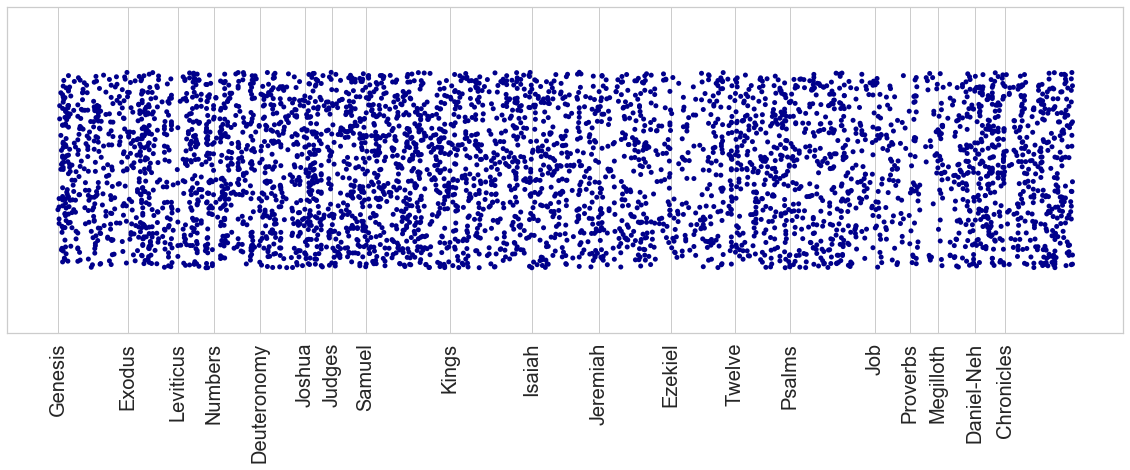

In [16]:
strip_title = 'Distribution of Time Function Constructions by segments of ~50 clauses (smaller books are grouped together)'
plt.figure(figsize=(20, 6))
sns.stripplot(x=strip_data, jitter=0.3, color='darkblue')
plt.xticks(ticks=list(bookboundaries.values()), labels=list(bookboundaries.keys()), rotation='vertical', size=20)
plt.savefig(fg_path('chapter_distribution.png'), dpi=300, bbox_inches='tight')
print(strip_title) # keep title out of savefig
print('x-axis: Nth clause cluster')
print('y-axis: random jitter effect for visibility')
plt.show()

We can see a slightly sparser population of time adverbials in some of the poetic books, especially Job-Proverbs.

## Top Surface Forms

In [23]:
surface_counts = collections.Counter()

for ta_cxs in time_cxs:
    slots = [s for ta in ta_cxs for s in ta.slots]
    surface = tokenize_surface(slots, A.api, feature='lex_sbl_l')
    surface_counts[surface] += 1
    
surfaces = convert2pandas(surface_counts)

In [24]:
surfaces.head(50)

,Total
ʿwd,344
ʿth,340
b.h.ywm.h.hwʾ,203
h.ywm,191
ʾz,117
l.ʿwlm,99
kl.h.ywm,84
b.h.bqr,78
ʿd.h.ywm.h.zh,71
ʾḥr,67


## Noun / Particle Distinction?

In the surface forms we can recognize numerous features which are common to phrases in Hebrew: prepositions, plural morphemes, definite articles, demonstratives. We also see modifications of number with cardinal number quantifiers or qualitative quantifiers like כל. **In the quest to specify the semantics and build semantic classes, we need to know how these various constructions relate to one another.** What does each element contribute to the whole? What is their relationship to one another? How does their use contribute to the precise meaning of a phrase? 

A cursory overview of the time adverbial surface forms above shows that not all time-words combine evenly with these features. Some regularly do, such as יום. But other words like עתה, אז, עולם seem to appear on their own more often, occasionally with a preposition. These are words that are often classified as "particles" or quintessential "adverbs".

### Variability Demonstrated: ʿwlm

A closer inspection of certain so-called particles reveals that these larger tendencies are not always absolute, but variable. Take עולם, for example. Below we count and reveal all of its surface forms.

In [25]:
olam_counts = collections.Counter()

for ta_cxs in time_cxs:
    cx = ta_cxs[0]
    head = list(cx.getsuccroles('head'))[-1]
    if F.lex.v(head) == '<WLM/':
        slots = [s for tcx in ta_cxs for s in tcx.slots]
        surface = tokenize_surface(slots, A.api, feature='lex_sbl_l')
        olam_counts[surface] += 1
        
olams = convert2pandas(olam_counts)

print('Surface form counts with ʿwlm as the head:')
olams

Surface form counts with ʿwlm as the head:


,Total
l.ʿwlm,99
ʿd.ʿwlm,53
ʿwlm,9
l.ʿwlm.w.ʿd,8
mn.ʿwlm,7
mn.h.ʿwlm.w.ʿd.h.ʿwlm,3
ʿwlm.w.ʿd,3
l.mn.ʿwlm.w.ʿd.ʿwlm,2
mn.h.ʿwlm,2
ʿd.l.ʿwlm,2


In [26]:
olams.sum()

Total    194
dtype: int64

Inspection of the various forms occuring with ʾwlm as the head shows variable preference for nominalizing constructions. The vast majority (>170/194) appear without modifications like definite articles and quantification. But a number of cases deploy nominalizing constructions such as definites and plurals.

**How do we account for both the tendencies and the variability of words like these?** And how does that inform our analysis of the semantics?

I propose, in line with the approach of Construction Grammar, to avoid assuming a univeral word class (e.g. "noun" versus "adverb"). Rather, parts-of-speech tendencies are manifested through collocational patterns. Some words may be highly associated with a given pattern, and the associations may even be semantically motivated. For instance, the word אישׁ will co-occur requently with patterns associated with (animate) objects. The high co-occurrence frequency is motivated by the meaning of the word itself. Framed in this way, we can talk more about a continuum of uses: a word may be more or less associated with contexts that indicate, for example, an object (traditionally a "noun"). 

Croft also treats parts of speech as a continuum of semantic features rather than discrete categories (Croft, *Radical Construction Grammar*, 2001). He provides the following illustration for constructions in English which characterize that continuum (2001: 99):

<img height=30% width=30% src="../../docs/images/figures/Croft_2001_POS_map.jpg">

Croft notes two axes along with language encodes certain functions. The y-axis denotes an object-to-action continuum, whereas the x-axis denotes a reference-to-predication continuum. Words that are prototypical nouns will co-occur often with constructions indicating referentiality (REF) and object attributes (OBJECT). This is the upper left-hand corner. Croft lists indicators of "number" as such a marker. On the opposite corner are words which are heavily construed as actions with predication, i.e. prototypical verbs. These co-occur with morpheme markers like tense or modality. 

Can we model this continuum somehow? Doing so would enable us to look for subtle collocational tendencies above the level of the phrase. For example, in a previous study, I found prelimary evidence that the *yiqṭol* verb tends to collocate with time adverbials which do not nominalize with features such as definite articles (see results [here](https://github.com/CambridgeSemiticsLab/BH_time_collocations/blob/master/archive/2019-10-31/analysis/exploratory/construction_clusters.ipynb)). Or, to put it simply, it seems that *yiq̣tol* prefers times with more particle-like than nominal behavior. If we were to have more precise data about time-word behavior, we could more accurately measure these kinds of clause-level tendencies.

### Collocation with Nominalizing Constructions

**If a word is distinguished by its collocational behavior, how can we quantify and reveal that behavior?** We will do that making a count of each time-adverbial, looking at its head and counting whether that head co-occurs with a "nominalizing" construction (see below). The counts are stored in a data frame. After making the counts we can normalize them so that words with different occurrence frequencies can be fairly compared. We will use a set of statistical methods to identify the main clusters and tendencies amongst the time words.

We will consider the following constructions as "nominalizing", i.e. they indicate a meaning in which the term is construed as a noun-like object:

* plural noun ending
* quantification with a cardinal number or qualitative quantifier (e.g. כל)
* modification with a definite article
* modification with a demonstrative pronoun 
* use with a prepositional modifier

We will *exclude* the following contexts:

* any phrase with a verbal (infinitive) head
* multi-phrasal time adverbials

The selection of single time adverbials is made below.

In [27]:
single_tas = class2cx['single'] - class2cx['component']

print(f'Number of single time adverbials: {len(single_tas)}')

Number of single time adverbials: 3823


The remaining time adverbials are now further filtered based on the exclusions noted above. They will be stored based on the lexeme string of their heads.

In [28]:
# map to head lexemes here
head2count = collections.defaultdict(lambda:collections.Counter()) # count: nom, ønom
contexts = collections.defaultdict(lambda:collections.defaultdict(list))

# apply filters to the tas, co
for ta in single_tas:
    
    head = list(ta.getsuccroles('head'))[-1] # head selected from graph
    head_cx = next(iter(ta.graph.pred[head]))
    
    # apply exclusions / filter
    exclusions = [
        F.sp.v(head) == 'verb',
    ]
    if any(exclusions):
        continue
    
    # make the collocation counts
    nominal_markers = {
        'pl.': F.nu.v(head) == 'pl',
        'quant.': (
            'quantified' in ta.classification 
            or F.nu.v(head) == 'du'
        ),
        'defi.': 'definite' in ta.classification,
        'demon.': 'demonstrative' in ta.classification,
        'prep.': 'prep' in ta.classification,
    }
    head_lex = F.lex_sbl_l.v(head)
    
    if not any(nominal_markers.values()):
        nominal_counts = {'ø': 1}
    else:
        nominal_counts = {
            tag:(1 if cond else 0) for tag, cond in nominal_markers.items()
        }
    
    head2count[head_lex].update(nominal_counts) 
    for tag, cond in nominal_counts.items():
        if cond:
            contexts[head_lex][tag].append(ta)
    
head_cols = pd.DataFrame.from_dict(head2count, orient='index').fillna(0)
head_cols = head_cols.loc[head_cols.sum(1).sort_values(ascending=False).index] # sort by row-sum

print(head_cols.shape)

(104, 6)


We now have a co-occurrence matrix that contains all of our counts. Let's have a look at the top values.

In [29]:
head_cols.head(10)

,ø,pl.,quant.,defi.,demon.,prep.
ywm,7.0,371.0,319.0,808.0,378.0,792.0
s̆nh,0.0,74.0,177.0,34.0,7.0,73.0
ʿth,345.0,0.0,0.0,0.0,2.0,6.0
ʿwd,345.0,0.0,0.0,0.0,0.0,7.0
ʿt,3.0,4.0,11.0,70.0,63.0,138.0
lylh,41.0,5.0,20.0,80.0,19.0,49.0
bqr,4.0,3.0,0.0,98.0,0.0,108.0
ʿwlm,6.0,5.0,0.0,3.0,0.0,165.0
ʿrb,0.0,0.0,7.0,75.0,0.0,76.0
ʾz,118.0,0.0,0.0,0.0,0.0,7.0


The `contexts` dictionary provides access to the particular instances seen in the data. For example, if we want to access the uses of `ʿth` used with a demonstrative (interesting cases!), we can do so:

In [30]:
for cx in contexts['ʿth']['demon.']:
    se.showcx(cx, condenseType='clause')

{   '__cx__': 'demon_ph',
    'demon': {'__cx__': 'prde', 'head': 198010},
    'head': {'__cx__': 'cont', 'head': 198009}}



{   '__cx__': 'demon_ph',
    'demon': {'__cx__': 'prde', 'head': 190309},
    'head': {'__cx__': 'cont', 'head': 190308}}



### Pruning

Some heads will occur only once or so. We will remove any cases with a sample size < 2.

In [31]:
head_cols_pruned = head_cols[head_cols.sum(1) > 1]

Here is the comparison of size after we've applied our pruning.

In [32]:
head_cols.shape # before

(104, 6)

In [33]:
head_cols_pruned.shape # after

(88, 6)

### Normalization: ratio

There are a number of ways to normalize the counts so that more and less common words are evenly compared. We can use a contingency-based method, which looks at each count in relation to the size of the dataset. This would allow us to isolate relationships which are statistically significant to a particular word. We can also use a non-contingency method such as a simple ratio (percentage). In this case, the ratio makes a bit more sense because we want to focus more closely on each word's own distributional tendencies. None of the data can be "statistically insignificant". The data is normalized below. Each decimal value is out of 1.

In [34]:
head_cols_ratio = head_cols_pruned.divide(head_cols_pruned.sum(axis=1), axis=0)

head_cols_ratio

,ø,pl.,quant.,defi.,demon.,prep.
ywm,0.002617,0.138692,0.119252,0.302056,0.141308,0.296075
s̆nh,0.000000,0.202740,0.484932,0.093151,0.019178,0.200000
ʿth,0.977337,0.000000,0.000000,0.000000,0.005666,0.016997
ʿwd,0.980114,0.000000,0.000000,0.000000,0.000000,0.019886
ʿt,0.010381,0.013841,0.038062,0.242215,0.217993,0.477509
...,...,...,...,...,...,...
zʿm,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000
kh,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
ʾs̆mrt,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
ywbl,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000


### Clustering: PCA

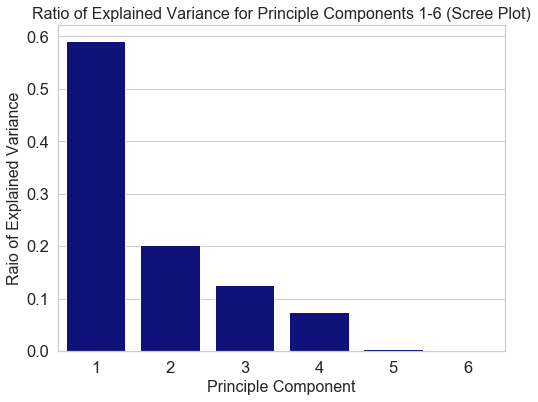

In [35]:
pca = PCA(6)
pca_fit = pca.fit(head_cols_ratio.values)
pca_values = pca_fit.transform(head_cols_ratio)

plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(6)+1, y=pca_fit.explained_variance_ratio_[:6], color='darkblue')
plt.xlabel('Principle Component', size=16)
plt.ylabel('Raio of Explained Variance', size=16)
plt.title('Ratio of Explained Variance for Principle Components 1-6 (Scree Plot)', size=16)
plt.show()

In [36]:
loadings = pca_fit.components_.T * np.sqrt(pca_fit.explained_variance_) # to CHECK!
loadings = pd.DataFrame(loadings.T, index=np.arange(6)+1, columns=head_cols_ratio.columns)

In [37]:
loadings.round(4)

,ø,pl.,quant.,defi.,demon.,prep.
1,0.3234,-0.0041,0.0152,-0.0248,0.0007,-0.3104
2,-0.1393,0.0779,0.0910,0.1115,0.0095,-0.1506
3,-0.0164,0.1198,0.0597,-0.1572,-0.0026,-0.0032
4,-0.0029,-0.0975,0.1234,-0.0273,-0.0022,0.0065
5,-0.0068,-0.0081,-0.0075,-0.0088,0.0378,-0.0066
6,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [38]:
def plot_PCA(components,
             dataset,
             loadings=None,
             zoom=tuple(), 
             save='', 
             title='', 
             text=True,
             text_size='18',
             tidy_text=False,
             dots='lightgrey',
             hebrew=False
            ):  

    x, y = components
    
    # plot coordinates
    plt.figure(figsize=(12, 10))
    plt.scatter(x, y, color=dots)

    if zoom:
        xmin, xmax, ymin, ymax = zoom
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
    
    plt.xlabel('PC1', size=18)
    plt.ylabel('PC2', size=18)
    plt.axhline(color='red', linestyle=':')
    plt.axvline(color='red', linestyle=':')
    
    # annotate points
    texts = []
    text_strings = dataset.index
    if hebrew:
        text_strings = [reverse_hb(s) for s in text_strings]
    if text:    
        for i, txt in enumerate(text_strings):
            tx, ty = x[i], y[i]
                        
            # to avoid plotting outside of field of view
            if zoom: 
                if any([
                    tx < xmin,
                    tx > xmax,
                    ty < ymin,
                    ty > ymax
                ]): continue
            texts.append(plt.text(
                tx, ty, txt, 
                size=text_size or 12,
                weight='bold',
            ))
    if loadings is not None:
        for feature in loadings:
            fx, fy = loadings[feature][:2]
            plt.arrow(0, 0, fx, fy, color='blue')
            plt.text(fx, fy, feature, color='blue', size=12) 
            
    if tidy_text:
        adjust_text(texts) # clean up overlapping annotations
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    # NB: keep title out of saves
    if title:
        plt.title(title, size=18) 
    plt.show()

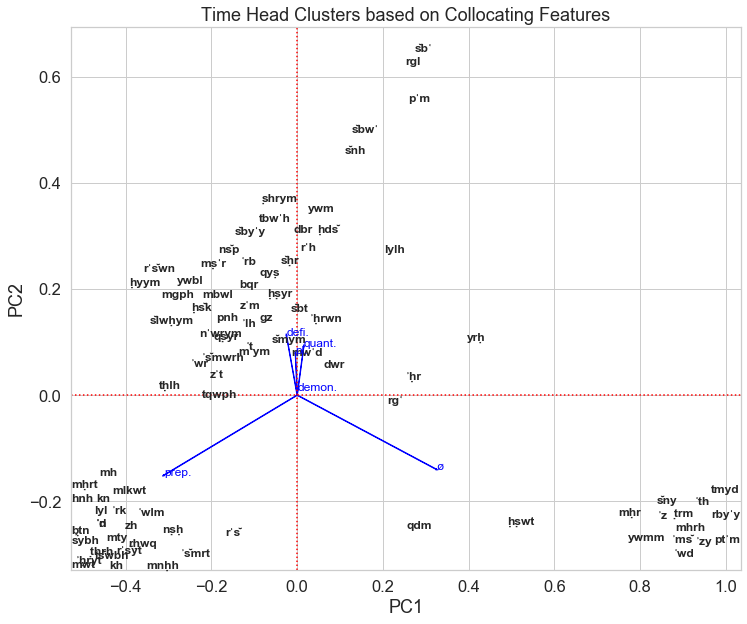

In [39]:
plot_PCA(
    (pca_values[:,0], pca_values[:,1]),
    head_cols_ratio, 
    loadings=loadings,
    title='Time Head Clusters based on Collocating Features',
    text_size=12,
    tidy_text=True,
    dots='',
    save=fg_path('time_head_clusters.png'),
)